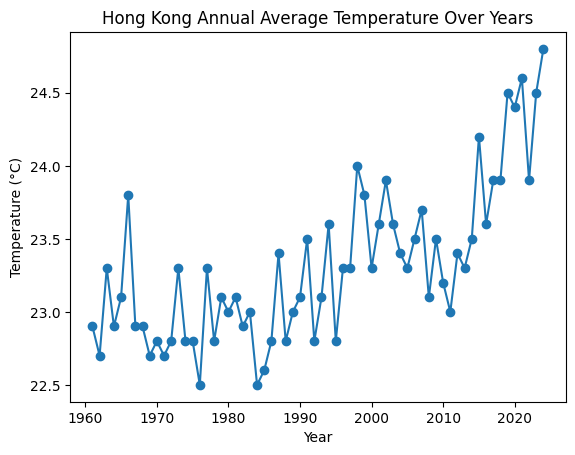

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#read hk temperature data
avg_temp = pd.read_csv('hktemp.csv')
#using plt show
plt.plot(avg_temp['Year'], avg_temp['avg_temp'], marker='o')
plt.title('Hong Kong Annual Average Temperature Over Years')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.show()

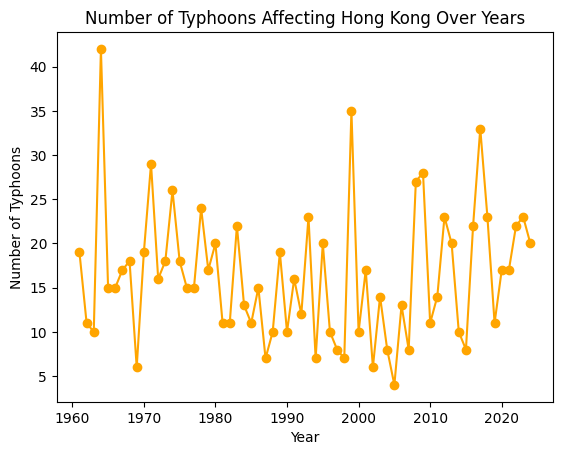

In [19]:
typhoon_num = pd.read_csv('hktyphoon.csv')

# Vectorized addition - pandas handles this natively
combine_list = typhoon_num['1'] + typhoon_num['3'] + typhoon_num['8_Total'] + typhoon_num['9'] + typhoon_num['10']

# Plot
plt.plot(typhoon_num['Year'], combine_list, marker='o', color='orange')
plt.title('Number of Typhoons Affecting Hong Kong Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Typhoons')
plt.show()

